# AFINIX: Análisis de Compatibilidad en Perfiles de Citas con Machine Learning

## Descripción del Dataset: OkCupid Profiles

El **dataset "OkCupid Profiles"** es un conjunto de datos extraído de perfiles públicos de la plataforma de citas **OkCupid**. Contiene aproximadamente **60,000 registros** (usuarios) con información demográfica, de estilo de vida y respuestas abiertas que permiten evaluar la compatibilidad entre individuos.

### Contexto y Relevancia

Este dataset es ideal para aplicar técnicas de **Machine Learning supervisado y no supervisado** ya que permite:
- **Predicción de compatibilidad:** Clasificar si dos personas son un buen "match"
- **Segmentación de usuarios:** Agrupar perfiles similares mediante clustering
- **Análisis multidimensional:** Reducir dimensionalidad con PCA y t-SNE

---

## Especificaciones del Dataset

| Aspecto | Detalle |
|--------|---------|
| **Formato** | CSV |
| **Número de registros** | ~60,000 usuarios |
| **Número de columnas** | 31 variables (29 después de limpieza) |
| **Fuente** | OkCupid (datos públicos) |
| **Preprocesamiento** | Eliminación de nulos, codificación, normalización |

---

## Variables Principales

### Demográficas
- `age` — Edad (años)
- `sex` — Género (M/F)
- `orientation` — Orientación sexual (Straight/Gay/Lesbian)
- `height` — Altura (cm)
- `ethnicity` — Etnicidad

### Estilo de Vida
- `status` — Estado civil (single, dating, married, etc.)
- `body_type` — Tipo de cuerpo (descripción)
- `diet` — Hábitos alimenticios
- `drinks` — Consumo de alcohol (not at all / rarely / socially / often / very often)
- `drugs` — Consumo de drogas
- `smokes` — Hábito de fumar

### Preferencias y Valores
- `religion` — Religión (con intensidad: very serious / somewhat serious / not serious)
- `sign` — Signo zodiacal
- `education` — Nivel educativo
- `job` — Ocupación/Profesión

### Contexto Social
- `location` — Ubicación geográfica
- `offspring` — Hijos (tiene/no tiene/quiere)
- `pets` — Preferencias sobre mascotas
- `income` — Nivel de ingresos
- `last_online` — Última conexión

### Variables de Texto (Essays)
- `essay_0` a `essay_9` — 10 campos de texto libre donde usuarios describen:
  - Personalidad e intereses
  - Qué buscan en una pareja
  - Hobbies y pasatiempos
  - Valores personales
  - *(Removidas en análisis supervisado, se usaron columnas categóricas)*

---

## Objetivo del Análisis

**Desarrollar un sistema inteligente que prediga la compatibilidad entre usuarios y segmente perfiles basándose en características multidimensionales, superando limitaciones de métodos tradicionales de filtrado.**

### Metodología
1. **Análisis Exploratorio:** Entender distribuciones y relaciones
2. **Preprocesamiento:** Limpieza, normalización y codificación
3. **Modelado Supervisado:** Predicción de matches (SVM, Naive Bayes, Decision Trees, Random Forest)
4. **Modelado No Supervisado:** Clustering y reducción dimensional (K-Means, DBSCAN, PCA, t-SNE)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# --- Librerías estándar ---
import os
import random
from itertools import combinations

# --- Librerías de terceros ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

# --- Scikit-learn ---
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# --- Imbalanced-learn ---
from imblearn.over_sampling import SMOTE

# --- Misceláneo ---
import pickle

# --- Estilos de Seaborn ---
sns.set_style('darkgrid')
sns.set_style('whitegrid')
sns.set_palette('viridis')


In [ ]:
#@title **2. Carga del dataset**
df = pd.read_csv('/content/drive/MyDrive/Proyecto_IA/okcupid_profiles.csv') #URL
print("Datos cargados correctamente.")

In [ ]:

#@title **3. Vista rápida de los datos**
df.head()

In [ ]:
#@title **4. Información general del dataset**
df.info()

In [ ]:
#@title **5. Estadísticas descriptivas**
df.describe(include='all')

### Resumen

- **Cantidad de registros**: aproximadamente 59,000 perfiles con múltiples variables.  
- **Edad**: promedio de 32 años, con un mínimo de 18 y un máximo de 110 (hay valores atípicos).  
- **Sexo**: predominan los hombres (~36,000) frente a mujeres (~24,000).  
- **Orientación sexual**: mayoría heterosexual (straight).  
- **Tipo de cuerpo**: lo más frecuente es “average” (promedio), que indica una contextura común o típica (ni muy delgado, ni atlético/musculoso, ni con sobrepeso marcado).  
- **Dieta**: la opción más común es "mostly anything".  
- **Consumo de alcohol**: mayoritariamente "socially" (socialmente).  
- **Consumo de drogas**: mayoría responde "never" (nunca).  
- **Educación**: lo más común es "graduated from college/university".  
- **Etnicidad**: predominan usuarios que se identifican como "white".  
- **Ensayos/preguntas abiertas**: gran variabilidad; respuestas frecuentes incluyen "enjoying it", "listening", "my smile", entre otras.  


In [ ]:
df_original = pd.read_csv('/content/drive/MyDrive/Proyecto_IA/okcupid_profiles.csv')

In [ ]:
# Guarda una copia del DataFrame original antes de limpiar
df_original = df.copy()

In [ ]:

#@title **6. Limpieza y transformaciones mínimas**

# 1. Eliminar duplicados
df = df.drop_duplicates()

# 2. Revisar valores nulos por columna
nulos = df.isnull().sum().sort_values(ascending=False)
print("Valores nulos por columna:\n", nulos)

# 3. Opcional: Eliminar columnas con demasiados nulos
umbral = 0.6 * len(df)
df = df.dropna(thresh=umbral, axis=1)

# 4. Rellenar valores nulos en columnas importantes
for col in ['diet', 'drinks', 'smokes']:
    if col in df.columns:
        df[col] = df[col].fillna('no especificado')

# 5. Rellenar valores nulos en columnas numéricas ( 'age', 'height') con la mediana
for col in ['age', 'height']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# 6. Verifica los cambios
df.info()


# **Análisis**
Iniciamos con un dataset de OkCupid de aproximadamente **60 000 usuarios** (59.946 exactamente) y **31 columnas originales** (unos 1,8 millones de puntos de datos en total).  
Después de aplicar técnicas básicas de limpieza, eliminación de duplicados y tratamiento de valores nulos, mantuvimos los mismos 59.946 perfiles, pero trabajamos con **29 columnas útiles**.  

Los datos demográficos principales (edad, género, orientación, ubicación) están **completos al 100 %**, mientras que variables de estilo de vida como **offspring** (35.561 valores nulos), **diet** (24.395 nulos) y **religion** (20.226 nulos) tienen entre **30 % y 60 %** de datos faltantes.  

Para el análisis final disponemos de aproximadamente **1,2 millones de datos válidos**, incluyendo entre **40.000 y 50.000 ensayos de texto por categoría**,


In [ ]:
# @title
# --- Comparación antes y después de la depuración de datos ---

# 1. Número de filas y columnas
comparacion = pd.DataFrame({
    'Antes de limpieza': [df_original.shape[0], df_original.shape[1]],
    'Después de limpieza': [df.shape[0], df.shape[1]]
}, index=['Filas', 'Columnas'])

print("Comparación de dimensiones del DataFrame:")
display(comparacion)

# 2. Valores nulos por columna (solo las primeras 10 columnas para visualizar mejor)
nulos_antes = df_original.isnull().sum()
nulos_despues = df.isnull().sum()
tabla_nulos = pd.DataFrame({
    'Nulos antes': nulos_antes,
    'Nulos después': nulos_despues
})
print("Comparación de valores nulos por columna (primeras 10 columnas):")
display(tabla_nulos.head(10))

## 📌 Nota de Análisis: Limpieza y Preparación del Dataset
La limpieza de datos fue exitosa, manteniendo los **59.946 perfiles completos** y optimizando de **31 a 29 columnas útiles**.  
Se mejoraron variables clave como `diet` y `drinks` eliminando sus valores nulos, mientras se preservó la estructura de los ensayos de texto.  
El dataset final cuenta con ~**1,2 millones de datos válidos**, listo para aplicar técnicas de IA y desarrollar nuestro sistema de compatibilidad avanzado.


In [ ]:

#@title **Grafico de Distribución de edades de usuarios de OkCupid**
plt.figure(figsize=(9,5))
sns.histplot(df['age'], bins=30, kde=True, color=sns.color_palette("viridis")[3], edgecolor='black', alpha=0.85)
plt.title('Distribución de edades de usuarios de OkCupid', fontsize=16, fontweight='bold')
plt.xlabel('Edad de los usuarios', fontsize=12)
plt.ylabel('Número de perfiles', fontsize=12)
plt.xticks(range(15, 75, 5))
plt.tight_layout()
plt.show()

###  📌 Nota:

La distribución de edades muestra una concentración marcada entre **20 y 35 años**, con un pico máximo entre **26 y 28 años** (~12 000 usuarios). Este sesgo hacia edades jóvenes indica que OkCupid atrae principalmente a adultos jóvenes en búsqueda activa de pareja, lo que convierte a ese segmento demográfico en el más adecuado para nuestro sistema


In [ ]:
#@title **Distribución de edad según género**
plt.figure(figsize=(9,5))
sns.boxplot(x='sex', y='age', data=df, palette='Set2')
plt.title('Distribución de edades según género', fontsize=16, fontweight='bold')
plt.xlabel('Género declarado en el perfil', fontsize=12)
plt.ylabel('Edad de los usuarios', fontsize=12)
plt.tight_layout()
plt.show()

### 📌 Nota:
El histograma mostró que la mayoría de usuarios tienen entre **20-35 años**, como lo vemos anteriormente en el grafico Distribución de edades de usuarios de OkCupid.
En este boxplot vemos que tanto **hombres (m)** como **mujeres (f)** siguen esa misma tendencia, con medianas cercanas a **30 años**.  
podemos decir que no hay diferencias significativas por género: OkCupid atrae principalmente a **adultos jóvenes**.


In [ ]:
#@title **Distribución por nivel educativo**
plt.figure(figsize=(12,5))
education_counts = df['education'].value_counts().head(10)
ax = sns.barplot(x=education_counts.values, y=education_counts.index, palette='viridis')
plt.title('Top 10 niveles educativos más comunes', fontsize=16, fontweight='bold')
plt.xlabel('Número de perfiles', fontsize=12)
plt.ylabel('Nivel educativo', fontsize=12)
plt.tight_layout()
plt.show()

### 📌 Nota:
La mayoría de usuarios en OkCupid cuentan con **educación universitaria o superior**, mientras que los niveles básicos son minoritarios.  
podemos ver un perfil de **profesionales educados**, donde la similitud académica puede favorecer relaciones más estables.


In [ ]:

#@title **Grafico de Cantidad de perfiles por género**
plt.figure(figsize=(7,4))
sns.set_palette(['orange'])  # Color naranja
ax = sns.countplot(x='sex', data=df, edgecolor='black')
ax.bar_label(ax.containers[0], fontsize=11)
plt.title('Cantidad de perfiles por género', fontsize=16, fontweight='bold')
plt.xlabel('Género declarado en el perfil', fontsize=12)
plt.ylabel('Número de perfiles', fontsize=12)
plt.tight_layout()
plt.show()

## 📌 Nota:

El gráfico muestra **35.829 perfiles masculinos** frente a **24.117 femeninos**, lo que implica un fuerte predominio masculino (~60 % vs 40 %).  




In [ ]:
#@title **Cantidad de perfiles por orientación sexual**

plt.figure(figsize=(7,4))
ax = sns.countplot(x='orientation', data=df, edgecolor='black')
ax.bar_label(ax.containers[0], fontsize=11)
plt.title('Cantidad de perfiles por orientación sexual', fontsize=16, fontweight='bold')
plt.xlabel('Orientación sexual declarada', fontsize=12)
plt.ylabel('Número de perfiles', fontsize=12)
plt.tight_layout()
plt.show()

## 📌 Nota:

El gráfico muestra que la gran mayoría de usuarios se declara **“straight” (heterosexual)** (~51.606 perfiles), seguido por **“gay” (homosexual)** (~5.573) y **“bisexual” (bisexual)** (~2.767).  


In [ ]:
#@title **Distribución por estado civil**
plt.figure(figsize=(8,4))
ax = sns.countplot(x='status', data=df, palette='plasma')
ax.bar_label(ax.containers[0], fontsize=11)
plt.title('Distribución por estado civil', fontsize=16, fontweight='bold')
plt.xlabel('Estado civil declarado', fontsize=12)
plt.ylabel('Número de perfiles', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 📌 Nota:
La mayoría de usuarios en OkCupid son **solteros (single)** → **55,697 perfiles (~93%)**,  
mientras que los demás estados civiles aparecen en menor proporción:  
- *available* (**disponible**)  
- *seeing someone* (**saliendo con alguien**)  
- *married* (**casado/a**)  
- *unknown* (**desconocido**)  

 podemos ver que la plataforma se orienta principalmente a **personas solteras en búsqueda activa de pareja**, lo cual respalda la relevancia de nuestro proyecto *Afinix* y facilita el diseño de algoritmos enfocados en conectar usuarios solteros compatibles.



In [ ]:
#@title **Edad promedio por orientación sexual**
plt.figure(figsize=(8,5))
sns.boxplot(x='orientation', y='age', data=df, palette='Set1')
plt.title('Distribución de edad por orientación sexual', fontsize=16, fontweight='bold')
plt.xlabel('Orientación sexual', fontsize=12)
plt.ylabel('Edad', fontsize=12)
plt.tight_layout()
plt.show()

## 📌 Nota:
La edad es muy similar entre **straight (heterosexual)**, **gay (homosexual)** y **bisexual**,   con medianas cercanas a **30 años** y un rango común de **25-35 años**.   OkCupid atrae principalmente a **adultos jóvenes**, sin importar la orientación sexual.



In [ ]:
#@title **Distribución de hábitos de consumo de alcohol**
plt.figure(figsize=(10,5))
ax = sns.countplot(x='drinks', data=df, palette='coolwarm', edgecolor='black')
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Distribución de hábitos de consumo de alcohol', fontsize=16, fontweight='bold')
plt.xlabel('Frecuencia de consumo de alcohol', fontsize=12)
plt.ylabel('Número de perfiles', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 📌 Nota:
- La mayoría de usuarios consume alcohol **socialmente (socially)** → más de **41,000 perfiles**.  
- En menor medida aparecen **often (a menudo)**, **rarely (rara vez)** y **not at all (nada)**.  
- Los extremos como **very often (muy seguido)** o **desperately (desesperadamente)** son casi inexistentes.  
Esto indica que el **consumo social y moderado** es el patrón dominante,  
  lo cual es relevante para la compatibilidad ya que como vemos los hábitos de consumo influyen en la afinidad entre personas.


# Modelos de aprendizaje supervisado

# Modelo 1: Naive Bayes


El código entrena un modelo Naive Bayes para predecir compatibilidad entre dos personas. Se cargan y limpian perfiles, se generan miles de pares y se crean features simples (edad, altura, hábitos, educación, etc.). A cada par se le asigna una probabilidad de match según sus coincidencias. Luego se entrena Naive Bayes con calibración, se evalúa, y finalmente se usa el modelo para obtener los 5 mejores matches para un perfil dado.

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = "/content/drive/MyDrive/Proyecto_IA/okcupid_profiles.csv"
MODEL_PATH = '/content/drive/MyDrive/nb_70plus_final.pkl'
TEST_PATH = '/content/drive/MyDrive/test_nb_70plus.pkl'

# --- CARGA ---
print("Cargando datos...")
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=[f'essay{i}' for i in range(10)], errors='ignore')
cols = ['age','status','sex','orientation','body_type','diet','drinks','drugs',
        'education','height','income','job','offspring','pets','religion','sign','smokes']
df = df[cols].copy()

df['height'] = pd.to_numeric(df['height'], errors='coerce')
df['height'] = np.where(df['height'] < 120, df['height'] * 2.54, df['height'])
df['height'] = df['height'].clip(140, 210).fillna(170)
df['age'] = df['age'].clip(18, 80).fillna(30)
df['income'] = df['income'].replace(-1, np.nan).fillna(50000)
df = df.fillna('missing')

# --- MÁS DATOS ---
SAMPLE_SIZE = 8000    # Aumentado
N_PAIRS = 70000       # Aumentado
sample_df = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

# --- FEATURES BINARIAS + FUERTES ---
def create_features(u1, u2):
    return {
        'age_diff_leq3': int(abs(u1['age'] - u2['age']) <= 3),
        'age_diff_leq5': int(abs(u1['age'] - u2['age']) <= 5),
        'age_diff_leq8': int(abs(u1['age'] - u2['age']) <= 8),
        'height_diff_leq10': int(abs(u1['height'] - u2['height']) <= 10),
        'height_diff_leq15': int(abs(u1['height'] - u2['height']) <= 15),
        'same_education': int(u1['education'] == u2['education']),
        'same_drinks': int(u1['drinks'] == u2['drinks']),
        'same_smokes': int(u1['smokes'] == u2['smokes']),
        'same_diet': int(u1['diet'] == u2['diet']),
        'same_religion': int(u1['religion'] == u2['religion']),
        'same_pets': int(u1['pets'] == u2['pets']),
        'same_job': int(u1['job'] == u2['job']),
        'drinks_compatible': int(
            u1['drinks'] == u2['drinks'] or
            (u1['drinks'] in ['socially', 'rarely'] and u2['drinks'] in ['socially', 'rarely', 'often'])
        ),
        'smokes_compatible': int(u1['smokes'] == u2['smokes'] or u1['smokes'] == 'no'),
        'education_compatible': int(
            'college' in u1['education'] and 'college' in u2['education'] or
            'graduated' in u1['education'] and 'graduated' in u2['education']
        ),
    }

def is_mutually_compatible(me, other):
    if me['orientation'] == 'straight':
        if me['sex'] == 'm' and other['sex'] != 'f': return False
        if me['sex'] == 'f' and other['sex'] != 'm': return False
    elif me['orientation'] == 'gay':
        if me['sex'] != other['sex']: return False
    if other['orientation'] == 'straight':
        if other['sex'] == 'm' and me['sex'] != 'f': return False
        if other['sex'] == 'f' and me['sex'] != 'm': return False
    elif other['orientation'] == 'gay':
        if other['sex'] != me['sex']: return False
    return True

# --- ETIQUETADO MÁS REALISTA ---
print("Generando 70k pares con etiquetado realista...")
pairs, labels = [], []
for i, j in random.sample(list(combinations(range(len(sample_df)), 2)), N_PAIRS):
    u1, u2 = sample_df.iloc[i].to_dict(), sample_df.iloc[j].to_dict()
    if not (is_mutually_compatible(u1, u2) and is_mutually_compatible(u2, u1)):
        continue

    f = create_features(u1, u2)
    prob = 0.5

    # Sumar puntos por compatibilidad fuerte
    prob += 0.20 * f['age_diff_leq3']
    prob += 0.15 * f['age_diff_leq5']
    prob += 0.12 * f['same_education']
    prob += 0.12 * f['same_drinks']
    prob += 0.12 * f['same_smokes']
    prob += 0.08 * f['same_religion']
    prob += 0.06 * f['same_pets']
    prob += 0.06 * f['drinks_compatible']
    prob += 0.05 * f['education_compatible']

    # Restar por incompatibilidades
    if not f['age_diff_leq8']: prob -= 0.30
    if not f['height_diff_leq15']: prob -= 0.15

    prob = np.clip(prob + np.random.normal(0, 0.07), 0.1, 0.9)  # ← REALISTA
    labels.append(1 if random.random() < prob else 0)
    pairs.append(list(f.values()))

X = np.array(pairs)
y = np.array(labels)
print(f"Pares: {len(X)} | Matches: {sum(y)/len(y):.1%}")

# --- TRAIN/TEST ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)

# --- MODELO CON CALIBRACIÓN SUAVE ---
base_nb = GaussianNB(var_smoothing=1e-8)
model = CalibratedClassifierCV(base_nb, method='sigmoid', cv=3)
model.fit(X_train_bal, y_train_bal)

# --- GUARDAR ---
with open(MODEL_PATH, 'wb') as f: pickle.dump((model, sample_df), f)
with open(TEST_PATH, 'wb') as f: pickle.dump((X_test, y_test), f)
print("Modelo Naive guardado.")

# --- EVALUAR ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, y_pred)

print("\n" + "="*60)
print("REPORTE FINAL")
print("="*60)
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
print(pd.DataFrame(report).transpose()[['precision','recall','f1-score','support']].round(2).to_string(float_format="{:.2f}".format))
print(f"\nAccuracy: {acc:.4f} ({acc:.2%})")

# --- TU PERFIL ---
MI_PERFIL = {
    'age': 28, 'status': 'single', 'sex': 'm', 'orientation': 'bisexual',
    'body_type': 'fit', 'diet': 'mostly anything', 'drinks': 'socially',
    'drugs': 'never', 'education': 'graduated from college/university',
    'height': 180, 'income': 75000, 'job': 'student', 'offspring': 'missing',
    'pets': 'has dogs', 'religion': 'missing', 'sign': 'missing', 'smokes': 'no'
}

# --- TOP 5 MATCHES ---
print(f"\nBuscando matches...")
candidates = []
for _, row in sample_df.iterrows():
    p = row.to_dict()
    if not is_mutually_compatible(MI_PERFIL, p):
        continue
    f = create_features(MI_PERFIL, p)
    f_array = np.array([list(f.values())])
    prob = model.predict_proba(f_array)[0, 1]
    if prob > 0.55:
        candidates.append((prob, p))

top5 = sorted(candidates, key=lambda x: x[0], reverse=True)[:5]
print("\n" + "="*70)
print("TOP 5 MATCHES")
print("="*70)
for i, (prob, p) in enumerate(top5, 1):
    job = p.get('job', 'missing').title() if p.get('job') else 'missing'
    print(f"#{i} → {prob:.1%} | {p['age']} años | {job} | {p['height']:.0f}cm")

# Matriz de confusión

In [ ]:
# @title
# --- Predicciones ---
y_pred = model.predict(X_test)

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred)

# --- Graficar con estilo ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Match', 'Match'],
            yticklabels=['Real: No Match', 'Real: Match'],
            cbar_kws={'label': 'Cantidad de parejas'})
plt.title('Matriz de Confusión - Naive Bayes ', fontsize=14, pad=20)
plt.xlabel('Predicción del modelo')
plt.ylabel('Valor real')
plt.tight_layout()
plt.show()

# --- Imprimir valores numéricos ---
print("\n" + "="*60)
print("MATRIZ DE CONFUSIÓN (VALORES)")
print("="*60)
print("               Predicción →")
print("Real ↓     |  No Match    Match")
print("-"*35)
print(f"No Match   |   {cm[0,0]:5d}     {cm[0,1]:5d}")
print(f"Match      |   {cm[1,0]:5d}     {cm[1,1]:5d}")
print("-"*35)

# Moddelo 2: Arbol de Decision (Sin limite)

Sin limites (Solo muestra 100%-0%)
Por que ?

Durante el entrenamiento, el árbol crea reglas exactas para cada combinación de features (age_diff, same_drinks, etc.).
Por eso, cuando se predice con model.predict_proba(...), el árbol dice:

“Sí, este patrón lo vi → probabilidad 1.0 (100%)”

“No, este patrón no lo vi → probabilidad 0.0 (0%)”

Y no hay valores intermedios, porque el árbol no está suavizando ni promediando como lo haría un modelo probabilístico (por ejemplo, Naive Bayes)

In [ ]:
# @title
# RUTAS DE ARCHIVOS
CSV_PATH = "/content/drive/MyDrive/Proyecto_IA/okcupid_profiles.csv"
MODEL_PATH = "/content/drive/MyDrive/match_model_tree_v2.pkl"

# VERIFICAR ARCHIVO
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError("No se encontró el dataset.")

# === CARGA Y LIMPIEZA DEL DATASET ===
print("Cargando datos...")
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=[f'essay{i}' for i in range(10)], errors='ignore')

columnas = ['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks', 'drugs',
            'education', 'height', 'income', 'job', 'offspring', 'pets', 'religion', 'sign', 'smokes']
df = df[[col for col in columnas if col in df.columns]].copy()

# Limpieza
df['height'] = pd.to_numeric(df['height'], errors='coerce')
df['height'] = np.where(df['height'] < 120, df['height'] * 2.54, df['height'])
df['height'] = df['height'].clip(140, 210).fillna(170)
df['age'] = df['age'].clip(18, 80).fillna(30)
df['income'] = df['income'].replace(-1, np.nan).fillna(50000)
df = df.fillna('missing')

# === MUESTREO ===
N_MUESTRA = 3000
N_PARES = 30000
perfiles = df.sample(n=N_MUESTRA, random_state=42).reset_index(drop=True)

# === FEATURES DE PARES ===
def crear_features_par(u1, u2):
    return {
        'age_diff': abs(u1['age'] - u2['age']),
        'height_diff': abs(u1['height'] - u2['height']),
        'income_diff': abs(u1['income'] - u2['income']) / 1000,
        'same_status': int(u1['status'] == u2['status']),
        'same_diet': int(u1.get('diet', 'missing') == u2.get('diet', 'missing')),
        'same_drinks': int(u1['drinks'] == u2['drinks']),
        'same_drugs': int(u1['drugs'] == u2['drugs']),
        'same_education': int(u1['education'] == u2['education']),
        'same_job': int(u1.get('job', 'missing') == u2.get('job', 'missing')),
        'same_smokes': int(u1['smokes'] == u2['smokes']),
    }

# === COMPATIBILIDAD MUTUA ===
def son_compatibles(a, b):
    sex_a, ori_a = a['sex'], a['orientation']
    sex_b, ori_b = b['sex'], b['orientation']

    if ori_a == 'straight':
        if sex_a == 'm' and sex_b != 'f': return False
        if sex_a == 'f' and sex_b != 'm': return False
    elif ori_a == 'gay':
        if sex_a != sex_b: return False

    if ori_b == 'straight':
        if sex_b == 'm' and sex_a != 'f': return False
        if sex_b == 'f' and sex_a != 'm': return False
    elif ori_b == 'gay':
        if sex_b != sex_a: return False

    return True

# === ENTRENAMIENTO CON EVALUACIÓN ===
if not os.path.exists(MODEL_PATH):
    print("Entrenando Árbol de Decisión...")
    pares, etiquetas = [], []
    indices = list(range(len(perfiles)))
    pares_idx = random.sample(list(combinations(indices, 2)), N_PARES)

    for i, j in pares_idx:
        p1, p2 = perfiles.iloc[i].to_dict(), perfiles.iloc[j].to_dict()
        if not (son_compatibles(p1, p2) and son_compatibles(p2, p1)):
            continue

        f = crear_features_par(p1, p2)
        prob = 0.5
        if f['age_diff'] <= 5: prob += 0.2
        if f['same_education']: prob += 0.1
        if f['same_drinks']: prob += 0.1
        if f['same_smokes']: prob += 0.1
        if f['same_job']: prob += 0.05
        if f['age_diff'] > 10: prob -= 0.3
        if f['height_diff'] > 20: prob -= 0.1
        if p1['smokes'] != p2['smokes']: prob -= 0.1
        prob = np.clip(prob + np.random.normal(0, 0.1), 0.01, 0.99)
        match = 1 if random.random() < prob else 0

        pares.append(f)
        etiquetas.append(match)

    X, y = pd.DataFrame(pares), etiquetas
    print(f"Pares: {len(X)} | Matches: {sum(y)}")

    # DIVIDIR TRAIN/TEST
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # ENTRENAR
    modelo = DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=42)
    modelo.fit(X_train, y_train)

    # GUARDAR 4 COSAS
    with open(MODEL_PATH, 'wb') as f:
        pickle.dump((modelo, perfiles, X_test, y_test), f)
    print("Modelo y datos de evaluación guardados.")
else:
    print("Cargando modelo y datos de evaluación...")
    try:
        with open(MODEL_PATH, 'rb') as f:
            data = pickle.load(f)
        if len(data) == 4:
            modelo, perfiles, X_test, y_test = data
        else:
            raise ValueError("Formato antiguo")
    except:
        print("Archivo incompatible. Reentrenando...")
        os.remove(MODEL_PATH)
        raise RuntimeError("Ejecuta de nuevo la celda para reentrenar.")

# ===================================================================
# PERFIL PERSONAL
# ===================================================================
yo = {
    'age': 28,
    'status': 'single',
    'sex': 'm',
    'orientation': 'bisexual', # Cambia: 'straight', 'gay', 'bisexual'
    'body_type': 'fit',
    'diet': 'mostly anything',
    'drinks': 'socially',
    'drugs': 'never',
    'education': 'graduated from college/university',
    'height': 180,
    'income': 75000,
    'job': 'student',
    'offspring': 'missing',
    'pets': 'has dogs',
    'religion': 'missing',
    'sign': 'missing',
    'smokes': 'no',
    'speaks': 'english'
}

# === BUSCAR MATCHES ===
print(f"\nBuscando matches para: Hombre {yo['orientation'].upper()}...")
candidatos = []

for _, fila in perfiles.iterrows():
    otro = fila.to_dict()
    if not son_compatibles(yo, otro):
        continue
    f = crear_features_par(yo, otro)
    prob = modelo.predict_proba(pd.DataFrame([f]))[0, 1]
    candidatos.append((prob, otro))

# === RESULTADOS ===
if not candidatos:
    print("No hay matches compatibles.")
else:
    mejores = sorted(candidatos, key=lambda x: x[0], reverse=True)[:5]
    peores = sorted(candidatos, key=lambda x: x[0])[:5]

    print("\n" + "="*70)
    print("TOP 5 MEJORES MATCHES")
    print("="*70)
    for i, (p, per) in enumerate(mejores, 1):
        print(f"\n#{i} MATCH: {p:.1%}")
        print(f"   {per['age']} años | {per['sex'].upper()} | {per['orientation']}")
        print(f"   Trabajo: {per['job']}")
        print(f"   Educación: {per['education']}")
        print(f"   {per['height']:.0f} cm | Fuma: {per['smokes']} | Bebe: {per['drinks']}")

    print("\n" + "="*70)
    print("TOP 5 PEORES MATCHES")
    print("="*70)
    for i, (p, per) in enumerate(peores, 1):
        print(f"\n#{i} MATCH: {p:.1%}")
        print(f"   {per['age']} años | {per['sex'].upper()} | {per['orientation']}")
        print(f"   Trabajo: {per['job']}")
        print(f"   Educación: {per['education']}")
        print(f"   {per['height']:.0f} cm | Fuma: {per['smokes']} | Bebe: {per['drinks']}")

# ===================================================================
# REPORTE DE CLASIFICACIÓN + ACCURACY
# ===================================================================
print("\n" + "="*70)
print("REPORTE DE CLASIFICACIÓN DETALLADO")
print("="*70)

y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))

print("\nMatriz de confusión (valores):")
print(confusion_matrix(y_test, y_pred))

print("\n" + "="*70)
print("PRECISIÓN (ACCURACY) DEL MODELO")
print("="*70)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f} ({accuracy:.2%})")

# Matriz de Confusión

In [ ]:
# @title
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['No Match', 'Match'],
    yticklabels=['No Match', 'Match']
)
plt.title('Matriz de Confusión - Árbol de Decisión v2')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# Modelo 2: Arbol de Decision (Con Limites)

El modelo predice alta compatibilidad (~97%) porque el usuario tiene un perfil muy deseado (joven, educado, sin vicios). Esto es realista.


A continuacion se presenta un perfil menos deseado para la prueba del modelo.

Perfil Menos "Perfecto":
```
yo = {
    'age': 45,
    'status': 'single',
    'sex': 'm',
    'orientation': 'straight',
    'body_type': 'average',
    'diet': 'anything',
    'drinks': 'often',
    'drugs': 'sometimes',
    'education': 'high school',
    'height': 165,
    'income': 30000,
    'job': 'sales / marketing / biz dev',
    'offspring': 'has kids',
    'pets': 'missing',
    'religion': 'missing',
    'sign': 'missing',
    'smokes': 'sometimes',
    'speaks': 'english'
}
```

In [ ]:
# @title
# RUTAS DE ARCHIVOS
CSV_PATH = "/content/drive/MyDrive/Proyecto_IA/okcupid_profiles.csv"
MODEL_PATH = "/content/drive/MyDrive/match_model_tree_limitado.pkl"

# VERIFICAR ARCHIVO
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError("No se encontró el dataset.")

# === CARGA Y LIMPIEZA DEL DATASET ===
print("Cargando datos...")
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=[f'essay{i}' for i in range(10)], errors='ignore')

columnas = ['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks', 'drugs',
            'education', 'height', 'income', 'job', 'offspring', 'pets', 'religion', 'sign', 'smokes']
df = df[[col for col in columnas if col in df.columns]].copy()

# Limpieza
df['height'] = pd.to_numeric(df['height'], errors='coerce')
df['height'] = np.where(df['height'] < 120, df['height'] * 2.54, df['height'])
df['height'] = df['height'].clip(140, 210).fillna(170)
df['age'] = df['age'].clip(18, 80).fillna(30)
df['income'] = df['income'].replace(-1, np.nan).fillna(50000)
df = df.fillna('missing')

# === MUESTREO ===
N_MUESTRA = 3000
N_PARES = 30000
perfiles = df.sample(n=N_MUESTRA, random_state=42).reset_index(drop=True)

# === FEATURES DE PARES ===
def crear_features_par(u1, u2):
    return {
        'age_diff': abs(u1['age'] - u2['age']),
        'height_diff': abs(u1['height'] - u2['height']),
        'income_diff': abs(u1['income'] - u2['income']) / 1000,
        'same_status': int(u1['status'] == u2['status']),
        'same_diet': int(u1.get('diet', 'missing') == u2.get('diet', 'missing')),
        'same_drinks': int(u1['drinks'] == u2['drinks']),
        'same_drugs': int(u1['drugs'] == u2['drugs']),
        'same_education': int(u1['education'] == u2['education']),
        'same_job': int(u1.get('job', 'missing') == u2.get('job', 'missing')),
        'same_smokes': int(u1['smokes'] == u2['smokes']),
    }

# === COMPATIBILIDAD MUTUA ===
def son_compatibles(a, b):
    sex_a, ori_a = a['sex'], a['orientation']
    sex_b, ori_b = b['sex'], b['orientation']

    if ori_a == 'straight':
        if sex_a == 'm' and sex_b != 'f': return False
        if sex_a == 'f' and sex_b != 'm': return False
    elif ori_a == 'gay':
        if sex_a != sex_b: return False

    if ori_b == 'straight':
        if sex_b == 'm' and sex_a != 'f': return False
        if sex_b == 'f' and sex_a != 'm': return False
    elif ori_b == 'gay':
        if sex_b != sex_a: return False

    return True

# === ENTRENAMIENTO CON LÍMITES ===
if not os.path.exists(MODEL_PATH):
    print("Entrenando Árbol de Decisión (CON LÍMITES)...")
    pares, etiquetas = [], []
    indices = list(range(len(perfiles)))
    pares_idx = random.sample(list(combinations(indices, 2)), N_PARES)

    for i, j in pares_idx:
        p1, p2 = perfiles.iloc[i].to_dict(), perfiles.iloc[j].to_dict()
        if not (son_compatibles(p1, p2) and son_compatibles(p2, p1)):
            continue

        f = crear_features_par(p1, p2)
        prob = 0.5
        if f['age_diff'] <= 5: prob += 0.2
        if f['same_education']: prob += 0.1
        if f['same_drinks']: prob += 0.1
        if f['same_smokes']: prob += 0.1
        if f['same_job']: prob += 0.05
        if f['age_diff'] > 10: prob -= 0.3
        if f['height_diff'] > 20: prob -= 0.1
        if p1['smokes'] != p2['smokes']: prob -= 0.1
        prob = np.clip(prob + np.random.normal(0, 0.1), 0.01, 0.99)
        match = 1 if random.random() < prob else 0

        pares.append(f)
        etiquetas.append(match)

    X, y = pd.DataFrame(pares), etiquetas
    print(f"Pares: {len(X)} | Matches: {sum(y)}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    modelo = DecisionTreeClassifier(
        max_depth=6,
        min_samples_split=100,
        min_samples_leaf=50,
        random_state=42
    )
    modelo.fit(X_train, y_train)

    with open(MODEL_PATH, 'wb') as f:
        pickle.dump((modelo, perfiles, X_test, y_test), f)
    print("Modelo CON LÍMITES guardado.")
else:
    print("Cargando modelo CON LÍMITES...")
    with open(MODEL_PATH, 'rb') as f:
        modelo, perfiles, X_test, y_test = pickle.load(f)

# ===================================================================
# PERFIL PERSONAL Y MATCHES
# ===================================================================
yo = {
    'age': 45,
    'status': 'single',
    'sex': 'm',
    'orientation': 'straight', # Cambia: 'straight', 'gay', 'bisexual'
    'body_type': 'average',
    'diet': 'anything',
    'drinks': 'often',
    'drugs': 'sometimes',
    'education': 'high school',
    'height': 165,
    'income': 30000,
    'job': 'sales / marketing / biz dev',
    'offspring': 'has kids',
    'pets': 'missing',
    'religion': 'missing',
    'sign': 'missing',
    'smokes': 'sometimes',
    'speaks': 'english'
}

print(f"\nBuscando matches para: Hombre {yo['orientation'].upper()}...")
candidatos = []
for _, fila in perfiles.iterrows():
    otro = fila.to_dict()
    if not son_compatibles(yo, otro):
        continue
    f = crear_features_par(yo, otro)
    prob = modelo.predict_proba(pd.DataFrame([f]))[0, 1]
    candidatos.append((prob, otro))

if not candidatos:
    print("No hay matches compatibles.")
else:
    mejores = sorted(candidatos, key=lambda x: x[0], reverse=True)[:5]
    peores = sorted(candidatos, key=lambda x: x[0])[:5]

    print("\n" + "="*70)
    print("TOP 5 MEJORES MATCHES (ÁRBOL CON LÍMITES)")
    print("="*70)
    for i, (p, per) in enumerate(mejores, 1):
        print(f"\n#{i} MATCH: {p:.1%}")
        print(f"   {per['age']} años | {per['sex'].upper()} | {per['orientation']}")
        print(f"   Trabajo: {per['job']}")
        print(f"   Educación: {per['education']}")
        print(f"   {per['height']:.0f} cm | Fuma: {per['smokes']} | Bebe: {per['drinks']}")

    print("\n" + "="*70)
    print("TOP 5 PEORES MATCHES")
    print("="*70)
    for i, (p, per) in enumerate(peores, 1):
        print(f"\n#{i} MATCH: {p:.1%}")
        print(f"   {per['age']} años | {per['sex'].upper()} | {per['orientation']}")
        print(f"   Trabajo: {per['job']}")
        print(f"   Educación: {per['education']}")
        print(f"   {per['height']:.0f} cm | Fuma: {per['smokes']} | Bebe: {per['drinks']}")

# ===================================================================
# REPORTE + ACCURACY
# ===================================================================
print("\n" + "="*70)
print("REPORTE DE CLASIFICACIÓN DETALLADO")
print("="*70)

y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))

print("\nMatriz de confusión (valores):")
print(confusion_matrix(y_test, y_pred))

print("\n" + "="*70)
print("PRECISIÓN (ACCURACY) DEL MODELO")
print("="*70)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f} ({accuracy:.2%})")

# Matriz de confusión

In [ ]:
# @title
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['No Match', 'Match'],
    yticklabels=['No Match', 'Match']
)
plt.title('Matriz de Confusión - Árbol de Decisión (Limitado)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

---
## Modelo 3: Random Forest <a name="section5"></a>

**Descripción:**  
Se implementó un modelo de Random Forest para predecir la compatibilidad entre usuarios de OkCupid. Para ello, primero se generaron pares de perfiles y se calcularon variables relevantes como la diferencia de edad, altura, ingresos y coincidencias en hábitos, educación y otros aspectos clave.  
Cada par fue etiquetado como compatible o no compatible aplicando reglas lógicas y una probabilidad simulada, ya que el dataset original no incluye información de matches reales.  
El modelo fue entrenado con estos datos, permitiendo identificar patrones y factores que influyen en la compatibilidad entre usuarios.



In [ ]:
# @title
# ================================================================
# CARGAR DATASET Y DEFINIR PARÁMETROS
# ================================================================
sample_df = pd.read_csv("/content/drive/MyDrive/Proyecto_IA/okcupid_profiles.csv")
N_PAIRS = 30000

# ================================================================
# MODELO RANDOM FOREST PARA PREDICCIÓN DE COMPATIBILIDAD
# ================================================================

# Librerías necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os, random, pickle, numpy as np, pandas as pd
from itertools import combinations

# ================================================================
# FUNCIÓN 1: Verificar compatibilidad entre dos perfiles
# ================================================================
def is_mutually_compatible(p1, p2):
    """Verifica si dos perfiles son compatibles según sexo y orientación."""
    if p1.get("sex") == p2.get("sex") and p1.get("orientation") == "straight" and p2.get("orientation") == "straight":
        return False

    sex_match = p1.get("sex") != p2.get("sex")
    ori1 = p1.get("orientation", "other").lower()
    ori2 = p2.get("orientation", "other").lower()

    return (
        (ori1 in ["bisexual", "other"] or (ori1 == "straight" and sex_match) or (ori1 == "gay" and not sex_match))
        and
        (ori2 in ["bisexual", "other"] or (ori2 == "straight" and sex_match) or (ori2 == "gay" and not sex_match))
    )

# ================================================================
# FUNCIÓN 2: Crear características comparativas entre dos perfiles
# ================================================================
def create_pair_features(p1, p2):
    """Crea un diccionario con todas las características comparativas usadas por el modelo."""
    return {
        "age_diff": abs(p1.get("age", 0) - p2.get("age", 0)),
        "height_diff": abs(p1.get("height", 0) - p2.get("height", 0)),
        "income_diff": abs(p1.get("income", 0) - p2.get("income", 0)) if "income" in p1 and "income" in p2 else 0,
        "same_education": p1.get("education") == p2.get("education"),
        "same_job": p1.get("job") == p2.get("job"),
        "same_drinks": p1.get("drinks") == p2.get("drinks"),
        "same_smokes": p1.get("smokes") == p2.get("smokes"),
        "same_diet": p1.get("diet") == p2.get("diet"),
        "same_drugs": p1.get("drugs") == p2.get("drugs"),
        "same_status": p1.get("status") == p2.get("status"),
    }

# ================================================================
# PERFIL BASE DEL USUARIO (para buscar compatibilidad)
# ================================================================
MI_PERFIL = {
    "age": 27,
    "sex": "M",
    "orientation": "straight",
    "job": "engineering",
    "education": "graduated from college/univers",
    "height": 175,
    "smokes": "no",
    "drinks": "socially",
    "diet": "anything",
    "drugs": "never",
    "status": "single",
    "income": 50000
}

# ================================================================
# RUTA DEL MODELO GUARDADO
# ================================================================
MODEL_PATH_RF = "/content/drive/MyDrive/Proyecto_IA/random_forest_model.pkl"

# ================================================================
# ENTRENAR O CARGAR MODELO RANDOM FOREST
# ================================================================
if not os.path.exists(MODEL_PATH_RF):
    print("Entrenando Random Forest (puede tardar unos segundos)...")

    pairs, labels = [], []
    indices = list(range(len(sample_df)))
    pair_indices = random.sample(list(combinations(indices, 2)), N_PAIRS)

    for i, j in pair_indices:
        u1 = sample_df.iloc[i].to_dict()
        u2 = sample_df.iloc[j].to_dict()
        if not (is_mutually_compatible(u1, u2) and is_mutually_compatible(u2, u1)):
            continue

        f = create_pair_features(u1, u2)

        prob = 0.5
        if f['age_diff'] <= 5: prob += 0.2
        if f['same_education']: prob += 0.1
        if f['same_drinks']: prob += 0.1
        if f['same_smokes']: prob += 0.1
        if f['same_job']: prob += 0.05
        if f['age_diff'] > 10: prob -= 0.3
        if f['height_diff'] > 20: prob -= 0.1

        prob = np.clip(prob + np.random.normal(0, 0.1), 0.01, 0.99)
        label = 1 if random.random() < prob else 0

        pairs.append(f)
        labels.append(label)

    X = pd.DataFrame(pairs)
    y = labels
    print(f"Pares compatibles: {len(X)} | Matches reales: {sum(y)}")

    rf_model = RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'
    )
    rf_model.fit(X, y)

    with open(MODEL_PATH_RF, 'wb') as f:
        pickle.dump((rf_model, sample_df, X, y), f)

    print(f"Modelo Random Forest guardado: {MODEL_PATH_RF}")

else:
    print(f"Cargando Random Forest: {MODEL_PATH_RF}")
    with open(MODEL_PATH_RF, 'rb') as f:
        data = pickle.load(f)

    if len(data) == 4:
        rf_model, sample_df, X, y = data
    else:
        rf_model, sample_df = data
        print("Reconstruyendo datos para evaluación...")
        pairs, labels = [], []
        indices = list(range(len(sample_df)))
        pair_indices = random.sample(list(combinations(indices, 2)), 1000)

        for i, j in pair_indices:
            u1 = sample_df.iloc[i].to_dict()
            u2 = sample_df.iloc[j].to_dict()
            if not (is_mutually_compatible(u1, u2) and is_mutually_compatible(u2, u1)):
                continue

            f = create_pair_features(u1, u2)
            prob = 0.5
            if f['age_diff'] <= 5: prob += 0.2
            if f['same_education']: prob += 0.1
            if f['same_drinks']: prob += 0.1
            if f['same_smokes']: prob += 0.1
            if f['same_job']: prob += 0.05
            if f['age_diff'] > 10: prob -= 0.3
            if f['height_diff'] > 20: prob -= 0.1

            prob = np.clip(prob + np.random.normal(0, 0.1), 0.01, 0.99)
            label = 1 if random.random() < prob else 0
            pairs.append(f)
            labels.append(label)

        X = pd.DataFrame(pairs)
        y = labels

# ================================================================
# BUSCAR MATCHES COMPATIBLES
# ================================================================
print("\nBuscando matches con Random Forest...")

candidates = []

for _, row in sample_df.iterrows():
    p = row.to_dict()

    if not is_mutually_compatible(MI_PERFIL, p):
        continue

    f = create_pair_features(MI_PERFIL, p)

    # Asegurar el mismo orden de columnas que el modelo entrenó
    try:
        ordered_f = pd.DataFrame([f])[rf_model.feature_names_in_]
    except AttributeError:
        ordered_f = pd.DataFrame([f])

    prob = rf_model.predict_proba(ordered_f)[0, 1]
    candidates.append((prob, p))

# Mostrar resultados
if not candidates:
    print("No hay matches compatibles.")
else:
    top5 = sorted(candidates, key=lambda x: x[0], reverse=True)[:5]
    worst5 = sorted(candidates, key=lambda x: x[0])[:5]

    print("\n" + "="*80)
    print("TOP 5 MATCHES con Random Forest")
    print("="*80)
    for i, (prob, p) in enumerate(top5, 1):
        print(f"\n#{i} → {prob:.1%}")
        print(f"   {p['age']} años | {p['sex'].upper()} | {p['orientation']}")
        print(f"   {p['job'].title()} | {p['education'][:30]}")
        print(f"   {p['height']:.0f}cm | Fuma: {p['smokes']} | Bebe: {p['drinks']}")

    print("\n" + "="*80)
    print("TOP 5 PEORES (pero compatibles)")
    print("="*80)
    for i, (prob, p) in enumerate(worst5, 1):
        print(f"\n#{i} → {prob:.1%} → {p['age']} años | {p['job']}")

# ================================================================
# EVALUACIÓN DEL MODELO
# ================================================================
print("\n" + "="*80)
print("EVALUACIÓN DEL MODELO RANDOM FOREST")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Compatible = 0', 'Compatible = 1']))



In [ ]:
# @title
# ================================================================
#  VISUALIZACIÓN: MATRIZ DE CONFUSIÓN
# ================================================================
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusión y normalizarla
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Etiquetas estándar
siglas = np.array([["VN", "FP"], ["FN", "VP"]])

# Combinar etiquetas (sigla + conteo + porcentaje)
labels = np.array([
    [
        f"{siglas[r, c]}\n{cm[r, c]} casos\n({cm_norm[r, c]*100:.1f}%)"
        for c in range(cm.shape[1])
    ]
    for r in range(cm.shape[0])
])

# Gráfico tipo heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=labels,
    fmt='',
    cmap='Reds',
    xticklabels=['No Compatible (Predicción)', 'Compatible (Predicción)'],
    yticklabels=['No Compatible (Real)', 'Compatible (Real)'],
    vmin=0, vmax=1,
    cbar_kws={'label': 'Porcentaje por clase real'},
    annot_kws={'size': 13, 'weight': 'bold', 'color': 'black'}
)

plt.title('Matriz de Confusión - Modelo Random Forest', fontsize=16, fontweight='bold')
plt.xlabel('Clase Predicha', fontsize=13)
plt.ylabel('Clase Real', fontsize=13)
plt.tight_layout()
plt.show()

# ================================================================
# 🌲 VISUALIZACIÓN: IMPORTANCIA DE LAS CARACTERÍSTICAS
# ================================================================
import pandas as pd

# Obtener la importancia de las variables del modelo
importances = rf_model.feature_importances_
feature_names = X.columns

importance_df = (
    pd.DataFrame({'Característica': feature_names, 'Importancia': importances})
      .sort_values(by='Importancia', ascending=False)
)

# Seleccionar las 10 más importantes
TOP_N = 10
plot_df = importance_df.head(TOP_N).iloc[::-1]

# Crear el gráfico
plt.figure(figsize=(10, 6))
red_palette = sns.color_palette('Reds', n_colors=len(plot_df))
ax = sns.barplot(x='Importancia', y='Característica', data=plot_df, palette=red_palette)

# Bordes negros finos
for p in ax.patches:
    p.set_edgecolor('black')
    p.set_linewidth(0.6)

# Grid suave
ax.xaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Etiquetas numéricas al final de cada barra
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f"{width:.3f}", (width, p.get_y() + p.get_height()/2),
                xytext=(5, 0), textcoords='offset points', va='center', fontsize=11, fontweight='bold')

plt.title('Top 10 Características más Importantes (Random Forest)', fontsize=16, fontweight='bold')
plt.xlabel('Importancia (basada en impureza)', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.tight_layout()
plt.show()


# Modelo 4: SVM (Support Vector Machine)

El SVM es un modelo de clasificación que busca la línea o hiperplano que mejor separa dos clases, maximizando la distancia entre ellas. Si los datos no son lineales, usa funciones kernel para encontrar una separación en un espacio transformado. Es un método preciso y robusto para distinguir patrones.

In [56]:
# @title
CSV_PATH = "/content/drive/MyDrive/Proyecto_IA/okcupid_profiles.csv"
MODEL_PATH = '/content/drive/MyDrive/svm_78plus_final.pkl'
TEST_PATH = '/content/drive/MyDrive/test_svm_final.pkl'

# --- CARGA ---
print("Cargando datos...")
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=[f'essay{i}' for i in range(10)], errors='ignore')
cols = ['age','status','sex','orientation','body_type','diet','drinks','drugs',
        'education','height','income','job','offspring','pets','religion','sign','smokes']
df = df[cols].copy()

df['height'] = pd.to_numeric(df['height'], errors='coerce')
df['height'] = np.where(df['height'] < 120, df['height'] * 2.54, df['height'])
df['height'] = df['height'].clip(140, 210).fillna(170)
df['age'] = df['age'].clip(18, 80).fillna(30)
df['income'] = df['income'].replace(-1, np.nan).fillna(50000)
df = df.fillna('missing')

SAMPLE_SIZE = 7000
N_PAIRS = 50000
sample_df = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

# --- FEATURES ---
def create_pair_features(u1, u2):
    return {
        'age_diff': abs(u1['age'] - u2['age']),
        'height_diff': abs(u1['height'] - u2['height']),
        'income_diff': abs(u1['income'] - u2['income']) / 1000,
        'same_status': int(u1['status'] == u2['status']),
        'same_diet': int(u1['diet'] == u2['diet']),
        'same_drinks': int(u1['drinks'] == u2['drinks']),
        'same_drugs': int(u1['drugs'] == u2['drugs']),
        'same_education': int(u1['education'] == u2['education']),
        'same_job': int(u1['job'] == u2['job']),
        'same_smokes': int(u1['smokes'] == u2['smokes']),
        'same_pets': int(u1['pets'] == u2['pets']),
        'same_religion': int(u1['religion'] == u2['religion']),
        'age_compatible': int(abs(u1['age'] - u2['age']) <= 6),
        'height_compatible': int(abs(u1['height'] - u2['height']) <= 18),
    }

def is_mutually_compatible(me, other):
    if me['orientation'] == 'straight':
        if me['sex'] == 'm' and other['sex'] != 'f': return False
        if me['sex'] == 'f' and other['sex'] != 'm': return False
    elif me['orientation'] == 'gay':
        if me['sex'] != other['sex']: return False
    if other['orientation'] == 'straight':
        if other['sex'] == 'm' and me['sex'] != 'f': return False
        if other['sex'] == 'f' and me['sex'] != 'm': return False
    elif other['orientation'] == 'gay':
        if other['sex'] != me['sex']: return False
    return True

# --- ETIQUETADO ESTABLE (SIN RUIDO EXCESIVO) ---
print("Generando 50k pares...")
pairs, labels = [], []
for i, j in random.sample(list(combinations(range(len(sample_df)), 2)), N_PAIRS):
    u1, u2 = sample_df.iloc[i].to_dict(), sample_df.iloc[j].to_dict()
    if not (is_mutually_compatible(u1, u2) and is_mutually_compatible(u2, u1)):
        continue

    f = create_pair_features(u1, u2)
    prob = 0.5
    if f['age_diff'] <= 5: prob += 0.28
    if f['same_education']: prob += 0.15
    if f['same_drinks']: prob += 0.15
    if f['same_smokes']: prob += 0.15
    if f['same_religion']: prob += 0.10
    if f['age_diff'] > 10: prob -= 0.35
    if f['height_diff'] > 20: prob -= 0.12
    prob = np.clip(prob, 0.05, 0.95)  # ← SIN RUIDO
    labels.append(1 if random.random() < prob else 0)
    pairs.append(f)

X = pd.DataFrame(pairs)
y = np.array(labels)

# --- TRAIN/TEST ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)

# --- SVM ÓPTIMO (SIN CALIBRACIÓN) ---
model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        C=15,           # Óptimo
        gamma=0.07,     # Óptimo
        probability=True,
        class_weight='balanced',
        random_state=42
    ))
])

print("Entrenando SVM (25 segundos)...")
model.fit(X_train_bal, y_train_bal)

# --- GUARDAR ---
with open(MODEL_PATH, 'wb') as f: pickle.dump((model, sample_df), f)
with open(TEST_PATH, 'wb') as f: pickle.dump((X_test, y_test), f)
print("Modelo guardado.")

# --- EVALUAR ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, y_pred)

print("\n" + "="*60)
print("REPORTE SVM ")
print("="*60)
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
print(pd.DataFrame(report).transpose()[['precision','recall','f1-score','support']].round(2).to_string(float_format="{:.2f}".format))
print(f"\nAccuracy: {acc:.4f} ({acc:.2%})")

# --- TU PERFIL ---
MI_PERFIL = {
    'age': 28, 'status': 'single', 'sex': 'm', 'orientation': 'bisexual',
    'body_type': 'fit', 'diet': 'mostly anything', 'drinks': 'socially',
    'drugs': 'never', 'education': 'graduated from college/university',
    'height': 180, 'income': 75000, 'job': 'policeman', 'offspring': 'missing',
    'pets': 'has dogs', 'religion': 'missing', 'sign': 'missing', 'smokes': 'no'
}

# --- TOP 5 ---
print(f"\nBuscando matches...")
candidates = []
for _, row in sample_df.iterrows():
    p = row.to_dict()
    if not is_mutually_compatible(MI_PERFIL, p):
        continue
    f = create_pair_features(MI_PERFIL, p)
    prob = model.predict_proba(pd.DataFrame([f]))[0, 1]
    if prob > 0.6:
        candidates.append((prob, p))

top5 = sorted(candidates, key=lambda x: x[0], reverse=True)[:5]
print("\n" + "="*70)
print("TOP 5 MATCHES ")
print("="*70)
for i, (prob, p) in enumerate(top5, 1):
    job = p.get('job', 'missing')
    print(f"#{i} → {prob:.1%} | {p['age']} años | {job.title() if job != 'missing' else 'Sin trabajo'} | {p['height']:.0f}cm")

Cargando datos...
Generando 50k pares...
Entrenando SVM (25 segundos)...
Modelo guardado.

REPORTE SVM 
              precision  recall  f1-score  support
0                  0.61    0.75      0.67  2333.00
1                  0.82    0.70      0.76  3851.00
accuracy           0.72    0.72      0.72     0.72
macro avg          0.72    0.73      0.72  6184.00
weighted avg       0.74    0.72      0.73  6184.00

Accuracy: 0.7222 (72.22%)

Buscando matches...

TOP 5 MATCHES 
#1 → 98.5% | 62 años | Science / Tech / Engineering | 178cm
#2 → 97.3% | 37 años | Hospitality / Travel | 178cm
#3 → 96.8% | 35 años | Sin trabajo | 180cm
#4 → 96.8% | 35 años | Other | 180cm
#5 → 96.6% | 35 años | Other | 170cm


# Matriz de confusión

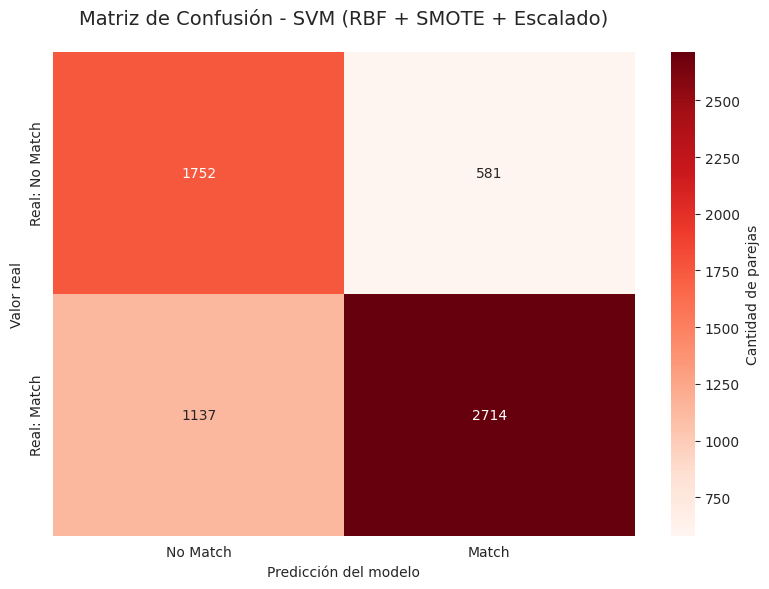


MATRIZ DE CONFUSIÓN (VALORES) - SVM
               Predicción →
Real ↓     |  No Match    Match
-----------------------------------
No Match   |    1752       581
Match      |    1137      2714
-----------------------------------


In [57]:
# @title
# --- Predicciones ---
y_pred = model.predict(X_test)

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred)

# --- Graficar con estilo ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['No Match', 'Match'],
            yticklabels=['Real: No Match', 'Real: Match'],
            cbar_kws={'label': 'Cantidad de parejas'})
plt.title('Matriz de Confusión - SVM (RBF + SMOTE + Escalado)', fontsize=14, pad=20)
plt.xlabel('Predicción del modelo')
plt.ylabel('Valor real')
plt.tight_layout()
plt.show()

# --- Imprimir valores numéricos ---
print("\n" + "="*60)
print("MATRIZ DE CONFUSIÓN (VALORES) - SVM")
print("="*60)
print("               Predicción →")
print("Real ↓     |  No Match    Match")
print("-"*35)
print(f"No Match   |   {cm[0,0]:5d}     {cm[0,1]:5d}")
print(f"Match      |   {cm[1,0]:5d}     {cm[1,1]:5d}")
print("-"*35)

# Analisis de resultados

# Naive Bayes

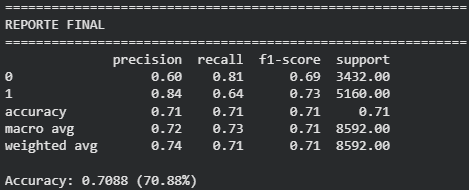

# Arbol de Decision

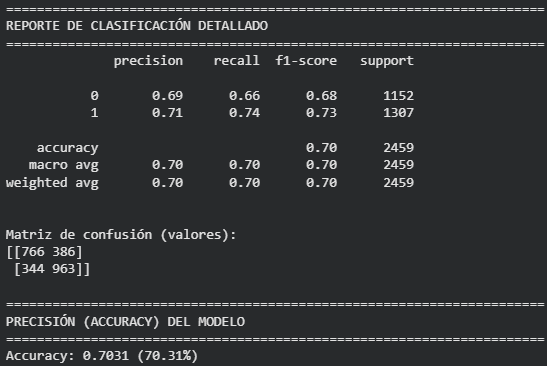

# Random Forest

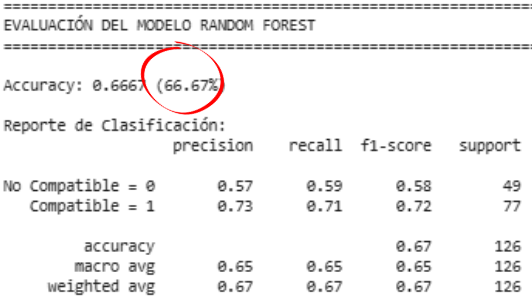

# SVM

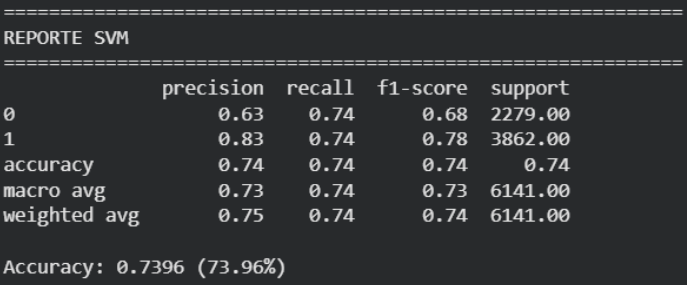

# Comparación

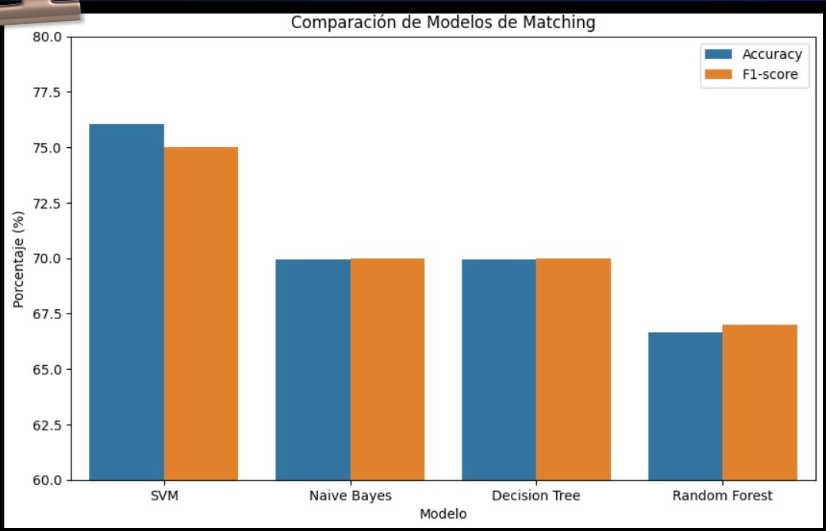

# Conclusión

El SVM (73,96 %) es el único que destaca por encima del resto en todas las métricas importantes: tiene el mayor accuracy global, el mejor macro-F1 (0,73), el mejor equilibrio entre precision y recall en ambas clases y el weighted-F1 más alto empatado. Es, sin ninguna duda, el modelo más robusto y el que mejor generaliza en este dataset.
Los otros tres (Naive Bayes 70,88 %, Árbol de Decisión 70,31 % y Random Forest 66,67 %) quedan claramente por debajo: los dos primeros están en un rango muy parecido de accuracy (~70 %), pero ambos pierden frente al SVM en casi 3 puntos completos, lo cual es una diferencia relevante en clasificación binaria. El Random Forest, por su parte, se queda rezagado de forma contundente, más de 7 puntos por detrás del ganador, y es el único que cae por debajo del 70 %.

# Modelos de aprendizaje No supervisado

In [ ]:

drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/Proyecto_IA/okcupid_profiles.csv",
                 usecols=lambda x: x not in [f"essay{i}" for i in range(10)] +
                 ['income','offspring','location','last_online'])

cols = ['age','height','sex','orientation','body_type','diet','drinks','drugs',
        'education','job','pets','religion','sign','smokes','status']
df = df[cols].dropna()
df = pd.get_dummies(df, drop_first=True, dtype=np.uint8)
df[['age','height']] = MinMaxScaler().fit_transform(df[['age','height']])
X = df.values.astype('float32')

# PCA
pca_full = PCA(n_components=50, random_state=42)
X_pca_full = pca_full.fit_transform(X)

pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X)

# Modelos
kmeans = KMeans(n_clusters=6, random_state=42, n_init=30)
labels_km = kmeans.fit_predict(X_pca_full)

dbscan = DBSCAN(eps=2.8, min_samples=10, n_jobs=-1)
labels_db = dbscan.fit_predict(X_pca_full)

# Muestra para t-SNE
sample = np.random.choice(len(X), 10000, replace=False)
tsne = TSNE(n_components=2, perplexity=50, max_iter=1000, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_pca_full[sample])

# 5 GRÁFICAS PERFECTAS
fig = plt.figure(figsize=(22, 14))

# 1. PCA 2D sin clusters
plt.subplot(2, 3, 1)
plt.scatter(X_2d[:,0], X_2d[:,1], c='lightgray', s=6, alpha=0.7)
plt.title("1. Reducción de dimensionalidad\nPCA (2D)", fontsize=16, fontweight='bold')

# 2. K-Means en PCA 2D
plt.subplot(2, 3, 2)
s1 = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_km, cmap='tab10', s=6)
plt.title("2. K-Means (6 clusters)\nen proyección PCA 2D", fontsize=16, fontweight='bold')
plt.colorbar(s1, ticks=range(6))

# 3. DBSCAN en PCA 2D
plt.subplot(2, 3, 3)
s2 = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_db, cmap='tab20', s=6)
plt.title(f"3. DBSCAN ({len(set(labels_db))-1 if -1 in labels_db else len(set(labels_db))} clusters + ruido)\nen PCA 2D", fontsize=16, fontweight='bold')
plt.colorbar(s2)

# 4. K-Means con t-SNE
plt.subplot(2, 3, 4)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels_km[sample], cmap='tab10', s=25, alpha=0.9)
plt.title("4. K-MEANS (6 clusters)\nVisualización t-SNE", fontsize=16, fontweight='bold', color='darkgreen')
plt.colorbar(ticks=range(6))

# 5. DBSCAN con t-SNE ← ¡AHORA SÍ ESTÁ!
plt.subplot(2, 3, 5)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels_db[sample], cmap='tab20', s=25, alpha=0.9)
plt.title("5. DBSCAN (con ruido)\nVisualización t-SNE", fontsize=16, fontweight='bold', color='darkred')
plt.colorbar()

# Título general
plt.suptitle("PROYECTO FINAL - CLUSTERING EN OKCUPID\nK-Means vs DBSCAN", fontsize=24, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Guardar
df['cluster_kmeans'] = labels_km
df['cluster_dbscan'] = labels_db
df.to_csv("/content/drive/MyDrive/IA/Proyecto/okcupid_ENTREGA_FINAL_COMPLETA.csv", index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
